In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-swing-on-ball.csv")

df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
# select season (zero indexed)
season = 13
df_balls = df_balls[df_balls["season"] == season]

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]  # * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]  # * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]  # * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2 / freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes


def get_pitcher_mul(row):
    bm = str(row["batter_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass  # traveling just doesn't do anything on pitchers?
    #         if not row["top_of_inning"]:
    #             mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #         mul += min(0.05, 0.05 * (row["day"] / 99))
        pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    #         pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        #         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
    #         pass
    return mul

In [3]:
# additions and corrections, global

df_balls["batter_mul"] = df_balls.apply(get_batter_mul, axis=1)
df_balls["pitcher_mul"] = df_balls.apply(get_pitcher_mul, axis=1)

df_balls.loc[df_balls["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df_balls.loc[df_balls["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

df_balls["ruth_scaled"] = df_balls["pitcher_ruthlessness"] * df_balls["pitcher_mul"]
df_balls["mox_scaled"] = df_balls["batter_moxie"] * df_balls["batter_mul"]


df_balls["invpath"] = 1 - df_balls["batter_patheticism"]
df_balls["invpath_scaled"] = 1 - df_balls["batter_patheticism"] / df_balls["batter_mul"]
df_balls["path_scaled"] = 1 - ((1 - df_balls["batter_patheticism"]) * df_balls["batter_mul"])
# df_balls["mox_path"] = df_balls["mox_scaled"] - df_balls["path_scaled"]
# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [4]:
# df = df[(df["batting_team_hype"] == 0) & (df['pitching_team_hype'] == 0)]

# df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * (1 + 0.2 * df_balls["pitcher_vibes"])
# df_balls["mox_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["mox_vibes"] = df_balls["mox_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# thought this might help but it seems not to help
df_balls["invpath_vibes"] = df_balls["invpath_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# beiju's idea
df_balls["visc_filth"] = df_balls["ballpark_viscosity"] * df_balls["ballpark_filthiness"]
# # put in our "best fit" up here in the original df, just because
# df['svc_best'] = 0.30 * df["ruth_scaled"] + 0.20 * df["ballpark_forwardness"] \
#                   + 0.06 * df["ruth_vibes"] + 0.10 * df["musc_scaled"]

df_balls["ruth_times_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["mox_times_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["path_times_vibes"] = df_balls["path_scaled"] * df_balls["batter_vibes"]


# kidror's idea
df_balls["ruth_sq"] = df_balls["ruth_vibes"] ** 2
df_balls["mox_sq"] = df_balls["mox_vibes"] ** 2
# df_balls["path_sq"] = df_balls["path_scaled"]**2 # not path_vibes
df_balls["visc_sq"] = df_balls["ballpark_viscosity"] ** 2

In [5]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]

# just look at swinging on balls first
dfc = df_balls
for exclude_mod in [
    "OVERPERFORMING",
    "UNDERPERFORMING",
    "HIGH_PRESSURE",
    "GROWTH",
    "SINKING_SHIP",
    "TRAVELING",
    "AFFINITY_FOR_CROWS",
    "CHUNKY",
    "SMOOTH",
    "ON_FIRE",
]:
    # for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    # exclude flinch situations entirely...superfluous i think, it doesn't roll when flinching
    dfc = dfc[~((dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0))]

In [6]:
# print(list(df_balls.columns))
print(57959, "old length of full csv")
print(len(df_balls))
print(len(dfc))

57959 old length of full csv
57957
34628


In [7]:
digest_list = [
    "event_type",
    "roll",
    "batter_name",
    "pitcher_name",
    "ruth_scaled",
    "pitcher_vibes",
    "musc_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    "svc_best",
]

In [8]:
# print(coef_list, intercept_scaled)
# print(X.columns)

In [9]:
dfc[dfc["passed"] == True]["roll"].max()

0.9492693003761858

In [10]:
dfc[dfc["passed"] == False]["roll"].min()

0.0022923664988039

In [11]:
# max for swings seems to be 0.95 so remove rolls above that
dfc = dfc[dfc["roll"] < 0.95]
# weird "cutoff" at 0.1 (though you can take pitches below this!) so remove rolls below that
dfc = dfc[dfc["roll"] > 0.1]
len(dfc)

29545

In [73]:
df_balls[(df_balls["passed"] == True) & (df_balls["roll"] < 0.1)]["threshold"].min()

0.1

In [14]:
dfc.groupby("batter_mul").head(1)[["batter_mul", "batter_name"]].sort_values("batter_mul", ascending=False)[0:10]

,batter_mul,batter_name
0,1.0,Farrell Seagull


In [15]:
print(list(df_balls.columns))

['Unnamed: 0', 'event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_contin

In [16]:
for dfs in [dfc, df_balls]:
    # calculate cross terms, I guess
    dfs["ruthsq"] = dfs["ruth_vibes"] * dfs["ruth_vibes"]
    dfs["pathsq"] = dfs["invpath_scaled"] * dfs["invpath_scaled"]
    # dfc['pathsq'] = dfc['invpath_vibes'] * dfc['invpath_vibes']
    dfs["moxsq"] = dfs["mox_vibes"] * dfs["mox_vibes"]
    dfs["viscsq"] = dfs["ballpark_viscosity"] * dfs["ballpark_viscosity"]
    dfs["ruthmox"] = dfs["ruth_vibes"] * dfs["mox_vibes"]
    dfs["ruthpath"] = dfs["ruth_vibes"] * dfs["invpath_scaled"]
    dfs["ruthvisc"] = dfs["ruth_vibes"] * dfs["ballpark_viscosity"]
    dfs["moxpath"] = dfs["mox_vibes"] * dfs["invpath_scaled"]
    dfs["moxvisc"] = dfs["mox_vibes"] * dfs["ballpark_viscosity"]
    dfs["pathvisc"] = dfs["invpath_scaled"] * dfs["ballpark_viscosity"]

    dfs["moxpluspath"] = dfs["mox_vibes"] + dfs["invpath_scaled"]
    dfs["mpsq"] = dfs["moxpluspath"] * dfs["moxpluspath"]
    dfs["ruthmp"] = dfs["ruth_vibes"] * dfs["moxpluspath"]
    dfs["viscmp"] = dfs["ballpark_viscosity"] * dfs["moxpluspath"]

    # doesn't work i think
    dfs["ruthpluseye"] = 0.5 * dfs["ruth_vibes"] + 0.2 * dfs["moxpluspath"]
    dfs["rutheyesq"] = dfs["ruthpluseye"] * dfs["ruthpluseye"]
    dfs["viscrutheye"] = dfs["ballpark_viscosity"] * dfs["ruthpluseye"]

In [17]:
# X = dfc[['roll', *dfc.columns[5:-11]]].drop('pitcher_name', axis=1).drop('batter_mods', axis=1)\
#     .drop('batting_team_mods', axis=1).drop('pitching_team_mods', axis=1).drop('pitcher_mods', axis=1)\
#     .drop('batter_vibes', axis=1).drop('pitcher_vibes', axis=1)\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness', 'pitcher_vibes_multiplied', 'batter_musclitude']]

# X = dfc[['roll', *dfc.columns[4:-42], 'batter_vibes', 'pitcher_vibes']]\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'ruth_vibes', 'path_vibes', 'mox_vibes', 'ballpark_viscosity']]#, 'mox_path', 'visc_filth']]
# X = dfc[['passed', 'roll', 'ruth_scaled', 'ballpark_forwardness', 'ruth_vibes', 'musc_scaled', 'flinch']]
# X = X[X['roll'] < 0.85]
X = dfc[
    [
        "roll",
        "ruth_vibes",
        "mox_vibes",
        "invpath_scaled",
        "ballpark_viscosity",
        "ruthsq",
        "pathsq",
        "moxsq",
        "viscsq",
        "ruthmox",
        "ruthpath",
        "ruthvisc",
        "moxpath",
        "moxvisc",
        "pathvisc",
    ]
]

# X = dfc[['roll', 'ruth_vibes', 'moxpluspath', 'ballpark_viscosity',
#          'ruthsq', 'mpsq', 'viscsq',
#          'ruthmp', 'ruthvisc', 'viscmp']]


# X = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled', 'ballpark_viscosity']]

y = dfc["passed"]
# X = X.drop('passed', axis=1)

In [18]:
X

,roll,ruth_vibes,mox_vibes,invpath_scaled,ballpark_viscosity,ruthsq,pathsq,moxsq,viscsq,ruthmox,ruthpath,ruthvisc,moxpath,moxvisc,pathvisc
0,0.134451,0.786526,1.011165,0.999000,0.263230,0.618624,0.998001,1.022454,0.069290,0.795308,0.785740,0.207037,1.010153,0.266168,0.262966
6,0.679864,0.786526,1.011165,0.999000,0.263230,0.618624,0.998001,1.022454,0.069290,0.795308,0.785740,0.207037,1.010153,0.266168,0.262966
8,0.614558,0.377605,0.404359,0.256128,0.481398,0.142585,0.065602,0.163506,0.231744,0.152688,0.096715,0.181778,0.103568,0.194658,0.123300
9,0.681459,0.786526,1.011165,0.999000,0.263230,0.618624,0.998001,1.022454,0.069290,0.795308,0.785740,0.207037,1.010153,0.266168,0.262966
10,0.185785,0.999588,0.789592,0.719674,0.432771,0.999176,0.517930,0.623456,0.187291,0.789267,0.719377,0.432593,0.568249,0.341713,0.311454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96424,0.280522,0.813605,1.293796,0.478432,0.496203,0.661953,0.228897,1.673909,0.246217,1.052639,0.389255,0.403713,0.618994,0.641985,0.237399
96426,0.816519,0.813605,0.473597,0.612314,0.496203,0.661953,0.374928,0.224294,0.246217,0.385321,0.498181,0.403713,0.289990,0.235000,0.303832
96427,0.514811,0.813605,0.473597,0.612314,0.496203,0.661953,0.374928,0.224294,0.246217,0.385321,0.498181,0.403713,0.289990,0.235000,0.303832
96429,0.191693,0.813605,0.926786,0.839000,0.496203,0.661953,0.703921,0.858933,0.246217,0.754038,0.682615,0.403713,0.777574,0.459874,0.416314


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[22324     6]
 [    6  7209]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       1.00      1.00      1.00      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [20]:
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)

0.9995938399052293

In [21]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

In [22]:
print(-intercept_scaled)
sorted(zip(-np.array(coef_list), X.columns), key=lambda x: abs(x[0]), reverse=True)

[0.12260844]


[(-1.0, 'roll'),
 (0.47275147159067765, 'ruth_vibes'),
 (-0.20292228588602154, 'mox_vibes'),
 (-0.19048645159886998, 'invpath_scaled'),
 (0.18662392042578546, 'ruthsq'),
 (0.16485656277578925, 'ballpark_viscosity'),
 (-0.1561025869469918, 'ruthpath'),
 (-0.1525407861121867, 'ruthmox'),
 (0.1249849822775406, 'ruthvisc'),
 (0.0644769086589313, 'moxpath'),
 (-0.055705353242086655, 'pathvisc'),
 (-0.04735871907789995, 'moxvisc'),
 (0.03321441939223516, 'moxsq'),
 (0.028500942070225598, 'pathsq'),
 (0.011171280410805257, 'viscsq')]

In [23]:
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity', 'ruthsq', 'pathsq', 'moxsq', 'viscsq', 'ruthmox',
       'ruthpath', 'ruthvisc', 'moxpath', 'moxvisc', 'pathvisc'],
      dtype='object')

In [77]:
# dfc["threshold"] = -1*(\
#     -0.10 + \
#     -0.65 * df_balls["ruth_vibes"] + \
#     0.27 * df_balls["mox_vibes"] + \
#     0.27 * df_balls["invpath_scaled"] + \
#     -0.20 * df_balls["ballpark_viscosity"])


dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
df_balls["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        if "sq" in pair[1]:
            print(np.sqrt(pair[0]))
        dfc["threshold"] += pair[0] * dfc[pair[1]]
        df_balls["threshold"] += pair[0] * df_balls[pair[1]]

df_balls.loc[(df_balls["threshold"] > 0.95), "threshold"] = 0.95
df_balls.loc[(df_balls["threshold"] < 0.10), "threshold"] = 0.10

a = 0.50
b = -0.20
c = 0.20

# dfc["threshold"] = 0.125 + \
#     a * dfc["ruth_vibes"] + \
#     b * dfc["moxpluspath"] + \
#     c * dfc["ballpark_viscosity"] + \
#     a**2 * dfc["ruthsq"] + \
#     b**2 * dfc["mpsq"] + \
#     2 * a * b * dfc["ruthmp"] + \
#     a * c * dfc["ruthvisc"] + \
#     b * c * dfc["viscmp"] + \
#     c**2 * dfc["viscsq"]


# dfc["threshold"] = 0.1 + \
#     0.5 * dfc["ruth_vibes"] + \
#     -0.20 * dfc["moxpluspath"] + \
#     0.16 * dfc["ballpark_viscosity"] + \
#     (a * dfc["ruth_vibes"] + b * dfc["moxpluspath"])**2 + \
#     a * c * dfc["ruthvisc"] + \
#     b * c *  dfc["viscmp"]# + \
#     c**2 * dfc["viscsq"]

# print(np.sqrt(-np.array(coef_list)))
# print(np.array(X.columns))
print(np.sqrt(-coef_list[4]) * np.sqrt(-coef_list[5]) * 2)

[0.12260844]
(0.47275147159067765, 'ruth_vibes')
(-0.20292228588602154, 'mox_vibes')
(-0.19048645159886998, 'invpath_scaled')
(0.16485656277578925, 'ballpark_viscosity')
(0.18662392042578546, 'ruthsq')
0.4319999079002048
(0.028500942070225598, 'pathsq')
0.16882222030948887
(0.03321441939223516, 'moxsq')
0.1822482356354518
(0.011171280410805257, 'viscsq')
0.10569427804193213
(-0.1525407861121867, 'ruthmox')
(-0.1561025869469918, 'ruthpath')
(0.1249849822775406, 'ruthvisc')
(0.0644769086589313, 'moxpath')
(-0.04735871907789995, 'moxvisc')
(-0.055705353242086655, 'pathvisc')
0.3508058041317868


37


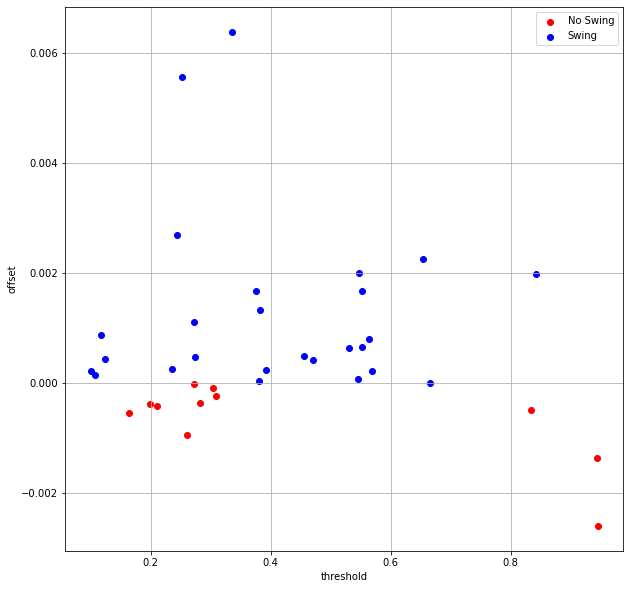

In [30]:
# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95
# dfc['polythreshold'] = polycoefs[0] + polycoefs[1]*dfc["threshold"] + polycoefs[2]*dfc["threshold"]**2
# df_balls['polythreshold'] = polycoefs[0] + polycoefs[1]*df_balls["threshold"] + polycoefs[2]*df_balls["threshold"]**2
# (0.05 + 0.7*x + 0.4*x**2)
# dfc['polythreshold'] = 0.05 + 0.7*dfc["threshold"] + 0.4*dfc["threshold"]**2
# df_balls['polythreshold'] = 0.05 + 0.7*df_balls["threshold"] + 0.4*df_balls["threshold"]**2
# df_balls.loc[(df_balls["polythreshold"] > 0.95), "polythreshold"] = 0.95
# df_balls.loc[(df_balls["polythreshold"] < 0.10), "polythreshold"] = 0.10

dfc["offset"] = dfc["roll"] - dfc["threshold"]
df_balls["offset"] = df_balls["roll"] - df_balls["threshold"]
# dfc["offset"] = dfc["roll"] - dfc["polythreshold"]
# df_balls["offset"] = df_balls["roll"] - df_balls["polythreshold"]


outliers = df_balls.copy()[
    (df_balls["passed"] & (df_balls["offset"] > 0)) | (~df_balls["passed"] & (df_balls["offset"] < 0))
]
# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
outliers = outliers[outliers["threshold"] > 0.1]
print(len(outliers))

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Swing",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Swing",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.grid()
ax.legend()
# ax.set_xlim(0.52, 0.54)
# ax.set_xlim(0, 1.0)
# ax.set_ylim(-0.01, 0.01)
fig.savefig("../figures/swing_fit_outliers.png", facecolor="white")

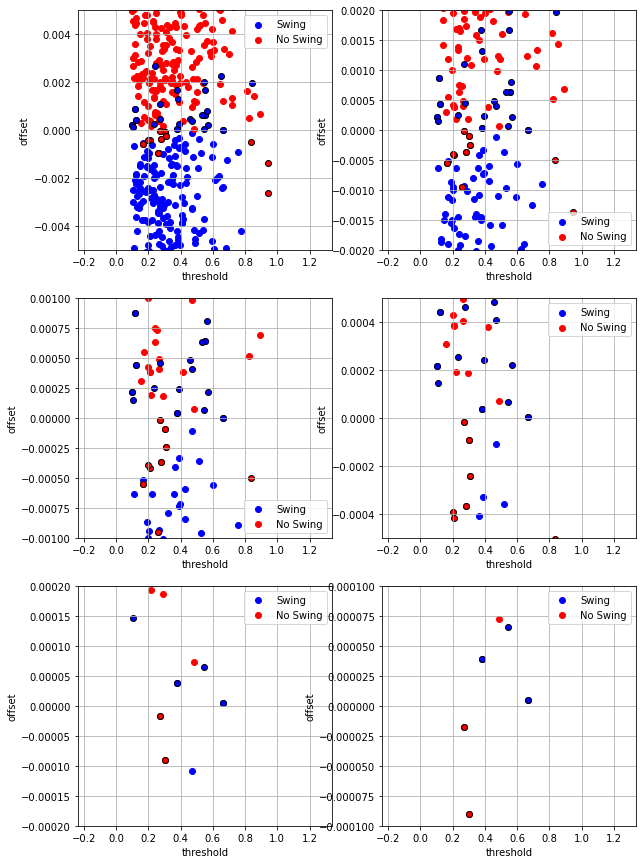

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Swing",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Swing",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    # ax.set_yscale("log")
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
fig.savefig("../figures/swing_ball_fit_offsets.png", facecolor="white")

[0.013573   0.95630158 0.05121252]


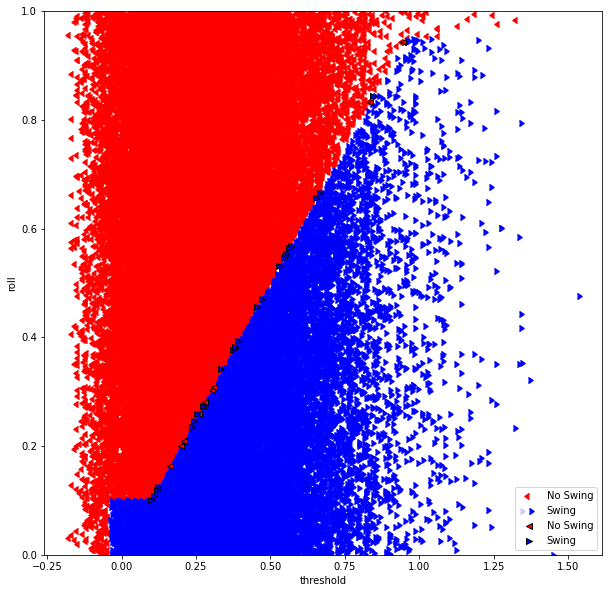

In [76]:
# x_val = "ruth_vibes"
x_val = "threshold"

y_val = df_balls
# y_val = dfc

polycoefs = (series_s.convert().coef + series_l.convert().coef) / 2
print(polycoefs)
linex = np.linspace(0, 1, 100)
fig, axN = plt.subplots(1, figsize=(10, 10))
# for axN in ax:
#     if axN == ax[0]:
axN.scatter(
    y_val[~y_val["passed"]][x_val],
    y_val[~y_val["passed"]]["roll"],
    color="red",
    label="No Swing",
    marker=CARETLEFTBASE,
)
axN.scatter(
    y_val[y_val["passed"]][x_val],
    y_val[y_val["passed"]]["roll"],
    color="blue",
    label="Swing",
    marker=CARETRIGHTBASE,
)
axN.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["roll"],
    color="red",
    marker="<",
    label="No Swing",
    edgecolor="k",
)
axN.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["roll"],
    color="blue",
    marker=">",
    label="Swing",
    edgecolor="k",
)
#     else:
#         axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
#         axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
#         axN.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"], color="red", marker = '<', label="No Swing", edgecolor='k')
#         axN.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"], color="blue", marker = '>', label="Swing", edgecolor='k')

#         axN.scatter(y_val[x_val], y_val["roll"], c=y_val['passed'], label="No Swing", marker='.')
#     axN.plot(linex, polycoefs[0] + polycoefs[1]*linex + polycoefs[2]*linex**2, 'k')
# ax.plot(np.linspace(0,1,100), series_s(np.linspace(0,1,100)), 'k')
# xline = np.array(ax.get_xlim())
# yline = -intercept_scaled + xline
# # yline = -0.2 + xline
# ax.plot(xline, yline, 'k')

axN.set_xlabel(x_val)
axN.set_ylabel("roll")
axN.set_ylim(0, 1)
# axN.set_xlim(-0.1, 0.1)
# axN.set_ylim(0, 0.2)
# ax.set_yscale('log')
# ax.set_xlim(0.484, 0.499)

axN.legend(loc="lower right")

fig.savefig("../figures/"+ x_val + ".png", facecolor="white")

In [33]:
col_list = [
    "event_type",
    "roll",
    "threshold",
    "offset",
    "mox_vibes",
    "invpath_scaled",
    "ruth_vibes",
    "batter_vibes",
    "pitcher_vibes",
    "batter_mul",
    "pitcher_mul",
    "ballpark_viscosity",
    "batter_name",
    "pitcher_name",
    "game_id",
    "play_count",
    "batter_mods",
    "pitcher_mods",
    "batting_team_mods",
    "pitching_team_mods",
    "day",
    "game_id",
    "play_count",
]
# outliers[(outliers['threshold'] > 0.1) &
#          (outliers["batter_mods"].astype(str).str.contains("ON_FIRE"))].sort_values('offset', ascending=True).loc[:, col_list][0:10]
outliers[(outliers["threshold"] > 0.1)].sort_values("offset", ascending=False).loc[:, col_list]

# 3805, 50620, 38777

,event_type,roll,threshold,offset,mox_vibes,invpath_scaled,ruth_vibes,batter_vibes,pitcher_vibes,batter_mul,...,pitcher_name,game_id,play_count,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
64778,StrikeSwinging,0.341557,0.335175,0.006382,0.371254,0.267499,0.491316,0.531314,-0.194077,1.050000,...,Bright Zimmerman,803368b8-7519-41ee-a278-9bfd3e3821d9,282,FLINCH;FIRE_EATER,NaN,TRAVELING,HIGH_PRESSURE,15,803368b8-7519-41ee-a278-9bfd3e3821d9,282
14697,Out,0.258178,0.252625,0.005553,1.270520,0.382159,0.822275,0.907094,0.618915,1.050000,...,Finn James,b0b272eb-0242-4b27-a5b0-1146cd4237f7,255,NaN,WILD,TRAVELING;PARTY_TIME,CARCINIZATION;UNHOLEY;PARTY_TIME,95,b0b272eb-0242-4b27-a5b0-1146cd4237f7,255
75152,StrikeSwinging,0.246333,0.243641,0.002691,0.748043,0.644669,0.722749,-0.133024,-0.333367,1.050000,...,Adalberto Tosser,061878a4-843e-4a69-a56f-3d6ae4651388,370,NaN,WILD;CREDIT_TO_THE_TEAM,TRAVELING,CARCINIZATION;UNHOLEY,30,061878a4-843e-4a69-a56f-3d6ae4651388,370
57328,StrikeSwinging,0.655478,0.653230,0.002248,0.148241,0.203383,0.825819,0.057555,-0.734716,1.004040,...,Cell Barajas,2281c84f-2dda-48b5-a312-c4c4f6a98fd8,39,NaN,NaN,GROWTH,NaN,8,2281c84f-2dda-48b5-a312-c4c4f6a98fd8,39
63621,StrikeSwinging,0.549463,0.547469,0.001994,0.885742,0.056529,1.016662,0.018447,-0.525818,1.000000,...,Elvis Figueroa,4fd1894e-c693-4add-8ac2-3699197cca02,202,NaN,NaN,BIRD_SEED,AFFINITY_FOR_CROWS,14,4fd1894e-c693-4add-8ac2-3699197cca02,202
91594,StrikeSwinging,0.844617,0.842646,0.001971,0.146828,0.218710,1.076084,-0.087040,0.319067,1.023737,...,Emmett Tabby,229de826-2f47-4a63-a71e-1cb8663417a1,262,NaN,NaN,GROWTH,NaN,47,229de826-2f47-4a63-a71e-1cb8663417a1,262
60768,Foul,0.553485,0.551806,0.001680,0.405817,0.209261,0.806589,0.334075,0.248940,1.010000,...,Oscar Vaughan,bb06d1ab-25d6-4478-941a-f8e659d69c59,193,NaN,ALTERNATE,SINKING_SHIP,NaN,11,bb06d1ab-25d6-4478-941a-f8e659d69c59,193
84261,StrikeSwinging,0.377372,0.375705,0.001667,0.155442,0.216003,0.472207,0.219217,0.785820,1.020202,...,Agan Harrison,e28943d4-092b-4892-bf82-edb94e31081c,131,NaN,NaN,GROWTH,NaN,40,e28943d4-092b-4892-bf82-edb94e31081c,131
91997,StrikeSwinging,0.382782,0.381461,0.001321,0.842297,0.056529,0.759018,-0.227704,-0.174597,1.000000,...,Ruslan Greatness,86020808-aad4-4f39-8b70-ee01585d1f87,109,NaN,FRIEND_OF_CROWS,BIRD_SEED,AFFINITY_FOR_CROWS,48,86020808-aad4-4f39-8b70-ee01585d1f87,109
77970,StrikeSwinging,0.273277,0.272178,0.001098,0.145814,0.213276,0.297310,-0.087040,-0.051557,1.016667,...,Enid Marlow,e1a55d80-cd91-4fe2-ac97-7cc5c4d4fd7c,306,NaN,NaN,GROWTH,BOTTOM_DWELLER,33,e1a55d80-cd91-4fe2-ac97-7cc5c4d4fd7c,306


In [35]:
# out1 = outliers.loc[24214,col_list]
# out1 = outliers.loc[26207,col_list]
out1 = outliers.loc[64778, col_list]
out1

event_type                                  StrikeSwinging
roll                                              0.341557
threshold                                         0.335175
offset                                            0.006382
mox_vibes                                         0.371254
invpath_scaled                                    0.267499
ruth_vibes                                        0.491316
batter_vibes                                      0.531314
pitcher_vibes                                    -0.194077
batter_mul                                            1.05
pitcher_mul                                            1.0
ballpark_viscosity                                  0.4862
batter_name                              Velasquez Alstott
pitcher_name                              Bright Zimmerman
game_id               803368b8-7519-41ee-a278-9bfd3e3821d9
play_count                                             282
batter_mods                              FLINCH;FIRE_EAT

In [36]:
# was this a strike?
# constant = 0.2 if not self.is_flinching() else 0.4
# threshold = constant + 0.3 * (ruth * (1 + 0.2 * vibes)) + 0.2 * fwd + 0.1 * musc
# threshold = min(threshold, 0.85)
# strike: 0.0.7059653767216438
# 0.2 + 0.3*out1['ruth_vibes'] + 0.2*out1['ballpark_forwardness'] + 0.1*out1['batter_musclitude']
# out1['threshold']

In [37]:
out1.roll

0.3415572828424105

In [38]:
-1 * (
    1.0 * coef_list[2] * out1["mox_vibes"]
    + 1.0 * coef_list[3] * out1["invpath_scaled"]
    + 1.0 * coef_list[1] * out1["ruth_vibes"]
    + 1.0 * coef_list[4] * out1["ballpark_viscosity"]
    + intercept_scaled[0]
)

0.30874143872257986

In [39]:
# print(out1['batter_moxie'] * (1 + 0.2*out1['batter_vibes'])*2.1)
print(out1["mox_vibes"], out1["mox_vibes"] / out1["batter_mul"])
# print(1*(1 - out1['batter_patheticism']))
print(out1["invpath_scaled"])

0.37125383623025743 0.3535750821240547
0.26749897579219317


In [43]:
# newpath = (1 - out1['batter_patheticism']/2.25)
# newpath

In [45]:
# newmox = out1['batter_moxie'] * (1 + 0.2*out1['batter_vibes'])*2.25
# newmox

In [47]:
# -1*(1.0 * newmox*0.26680261578837383 + \
#     1.0 * 0.27074297728503854*newpath + \
#     1.0 * -0.6493800663604212*out1['ruth_vibes'] + \
#     1.0 * -0.2178580998442087*out1['ballpark_viscosity'] + \
#     intercept_scaled[0])

In [48]:
coef_list

[1.0,
 -0.47275147159067765,
 0.20292228588602154,
 0.19048645159886998,
 -0.16485656277578925,
 -0.18662392042578546,
 -0.028500942070225598,
 -0.03321441939223516,
 -0.011171280410805257,
 0.1525407861121867,
 0.1561025869469918,
 -0.1249849822775406,
 -0.0644769086589313,
 0.04735871907789995,
 0.055705353242086655]

In [49]:
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity', 'ruthsq', 'pathsq', 'moxsq', 'viscsq', 'ruthmox',
       'ruthpath', 'ruthvisc', 'moxpath', 'moxvisc', 'pathvisc'],
      dtype='object')

In [50]:
intercept_scaled

array([-0.12260844])

In [51]:
# let's do *another svc* but polynomial this time
Xp = dfc[["roll", "threshold"]]

scp = StandardScaler()
Xp2 = scp.fit_transform(Xp)

trainedsvm_p = svm.SVC(kernel="poly", degree=3, max_iter=1000000, C=1000).fit(Xp2, y)
predictionsvm_p = trainedsvm_p.predict(Xp2)
print(confusion_matrix(y, predictionsvm_p))
print(classification_report(y, predictionsvm_p))

[[22327     3]
 [    3  7212]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       1.00      1.00      1.00      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [52]:
trainedsvm_p.intercept_

array([-34.14825151])

In [53]:
swings = dfc[dfc["passed"]]
looks = dfc[~dfc["passed"]]

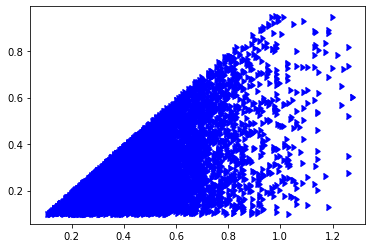

In [54]:
plt.scatter(swings[x_val], swings["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
# plt.plot(x, series_s(x),'k')

In [55]:
swings["threshold"].min()

0.10006286381351703

In [56]:
x = np.arange(0.24, 0.8, 0.001)
y_s = np.zeros(x.shape)
y_l = np.zeros(x.shape)
for i, n in enumerate(x):
    y_s[i] = swings[((swings["threshold"] > n) & (swings["threshold"] <= n + 0.01))]["roll"].max()
    y_l[i] = looks[((looks["threshold"] > n) & (looks["threshold"] <= n + 0.01))]["roll"].min()

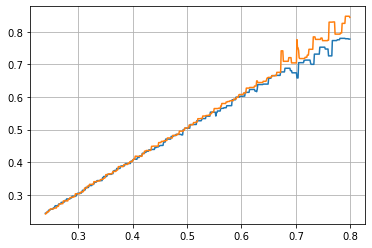

In [57]:
plt.plot(x, y_s)
plt.plot(x, y_l)
plt.grid()

In [58]:
from numpy.polynomial import Polynomial

series_s = Polynomial.fit(x, y_s, 2)
series_l = Polynomial.fit(x, y_l, 2)

In [59]:
print(series_s)
print(series_l)

0.522377130954324 + 0.2709790420212396·x¹ - 0.0076005536267546294·x²
0.5260087159403792 + 0.2933378245153809·x¹ + 0.01560202291057023·x²


In [60]:
series_s.convert()

Polynomial([-0.00754263,  1.070601  , -0.097293  ], domain=[-1.,  1.], window=[-1.,  1.])

In [61]:
series_l.convert()

Polynomial([0.03468863, 0.84200217, 0.19971804], domain=[-1.,  1.], window=[-1.,  1.])

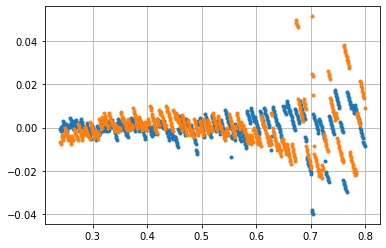

In [72]:
plt.plot(x, y_s - series_s(x), ".")
plt.plot(x, y_l - series_l(x), ".")
# plt.plot(x, y_s - (0.05 + 0.7*x + 0.4*x**2), '.')
# plt.plot(x, y_l - (0.05 + 0.7*x + 0.4*x**2), '.')
plt.grid()

In [63]:
print((series_s.convert().coef + series_l.convert().coef) / 2)

[0.013573   0.95630158 0.05121252]


In [64]:
# let's do *another svc* but polynomial this time
Xpp = dfc[["roll", "ruth_vibes", "mox_vibes", "invpath_scaled", "ballpark_viscosity"]]

scpp = StandardScaler()
Xpp2 = scp.fit_transform(Xpp)

trainedsvm_pp = svm.SVC(kernel="poly", degree=3, max_iter=100000000, C=100000).fit(Xpp2, y)
predictionsvm_pp = trainedsvm_pp.predict(Xpp2)
print(confusion_matrix(y, predictionsvm_pp))
print(classification_report(y, predictionsvm_pp))

[[22327     3]
 [    4  7211]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       1.00      1.00      1.00      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [65]:
from sklearn.inspection import DecisionBoundaryDisplay

(-4.0, 4.0)

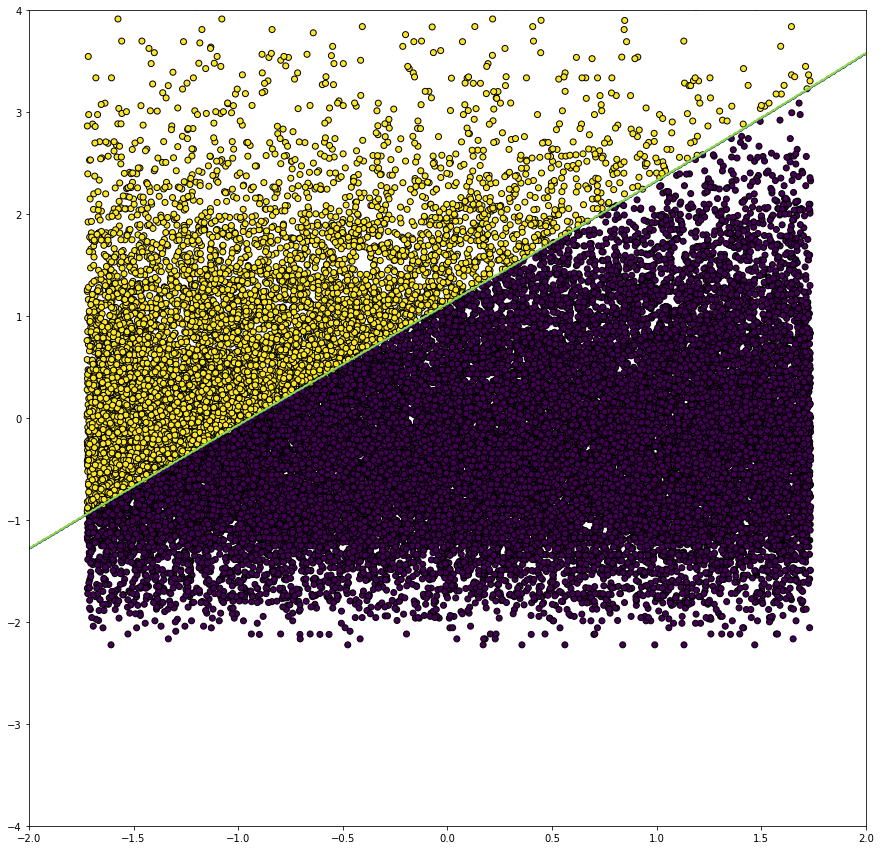

In [66]:
fig, ax = plt.subplots(1, figsize=(15, 15))
disp = DecisionBoundaryDisplay.from_estimator(
    trainedsvm_p,
    Xp2,
    plot_method="contour",
    ax=ax,
    response_method="predict",
    grid_resolution=1000,
)

disp.ax_.scatter(Xp2[:, 0], Xp2[:, 1], c=y, edgecolor="k")
ax.set_xlim(-2, 2)
ax.set_ylim(-4, 4)

In [69]:
# plt.scatter?

In [68]:
trainedsvm.get_params()

{'C': 1000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}